- go image by image
- detect object
- save frame
- cut image
- save cutted image

Saved cutted file: `/content/drive/My Drive/magisterka22/dane/Version2/Train/Rectangle/HighFatDiet/Kopia HFD2tyg_N07_T1maps_cutted.npy`

Saved mask: `/content/drive/My Drive/magisterka22/dane/HeartMasks/Train/Rectangle/HighFatDiet/Kopia HFD2tyg_N07_T1maps_mask.npy`

# Set Up

In [ ]:
import scipy.io
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import copy

from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.filters import threshold_otsu
from skimage import data

In [ ]:
# This will prompt for authorization.
drive.mount('/content/drive')

# After executing the cell above, Drive
# files will be present in "/content/drive/My Drive".
!ls "/content/drive/My Drive/magisterka22/dane"

Mounted at /content/drive
HeartMasks		HighFatDiett  Version0	Version2
HFD2tyg_N01_T1maps.mat	Kontrolaa     Version1


In [ ]:
DATA_DIR = '/content/drive/My Drive/magisterka22/dane/Version1/Train/'
OUT_DIR = '/content/drive/My Drive/magisterka22/dane/Version2/Train/'
MASKS_DIR = '/content/drive/My Drive/magisterka22/dane/HeartMasks/Train/'

FAT_DIR = 'Square/HighFatDiet'
HEALTHY_DIR = 'Square/Kontrola'
FAT_DIR1 = 'Rectangle/HighFatDiet'
HEALTHY_DIR1 = 'Rectangle/Kontrola'

# Functions

In [ ]:
def fix_image(im, min_size=192): #it shold be do one and decide the dirrection
  (x, y) = im.shape
  #print("before fix x:",x," y:", y)
  if x < min_size:
    im = np.concatenate((im, np.zeros((min_size-x, y))))
  (x, y) = im.shape
  #print("after first fix x:",x," y:", y)
  if y < min_size:
    im = np.concatenate((im, np.zeros((x, min_size-y))), axis=1)
  return im

def load_image(filepath, label, pre = False, rgb = False):
  maps = scipy.io.loadmat(filepath)
  #print(maps.keys())
  img_pre = np.array(maps['preT1map'], np.double)
  img_pre = fix_image(img_pre)
  img_post = np.array(maps['postT1map'], np.double)
  img_post = fix_image(img_post)
  if rgb:
    img_pre = toRGB(img_pre)
    img_post = toRGB(img_post)
  if pre:
    return (img_pre, label)
  return (img_post, label)

def toRGB(image):
  #image = image/2500
  rgb_image = np.stack((image, image, image), axis=2)
  return rgb_image

def prep_mask(x, y, mask=np.zeros((192,192))):
  for i in range(5):
    mask[x-i][y] = 1000
    mask[x+i][y] = 1000
    mask[x][y-i] = 1000
    mask[x][y+i] = 1000
  return mask

def visualize_cords(cords, mask= np.zeros((192,192))):
  for x,y in cords:
    mask = prep_mask(x,y,mask)
  return mask

def cat_from_img(img, out_size, x, y):
  return img[x:(x+out_size), y:(y+out_size)]

# Data

In [ ]:
class PyTorchImageDataset(Dataset):
    def __init__(self, data_dir, fat_label, transforms=None):
        all = [(load_image(os.path.join(data_dir, filename), fat_label, True, rgb=False), filename) for filename in os.listdir(data_dir)]
        # healthy = [(load_image(os.path.join(healthy_dir, filename), 0, True, rgb), filename) for filename in os.listdir(healthy_dir)]
        # all = np.array(fat + healthy)
        self.image_list = [x[0][0] for x in all]
        self.labels = [x[0][1] for x in all]
        self.filenames = [x[1] for x in all]
        self.transforms = transforms
         
    def __len__(self):
        return (len(self.image_list))
    
    def __getitem__(self, i):
        image = self.image_list[i]    
        image = np.array(image/10).astype(np.uint8) #TODO when rgb
        #image = np.array(image).astype(np.float32)
        if self.transforms is not None:
            image = self.transforms(image) 
        #image = image/2500 
        return (torch.tensor(image, dtype=torch.float), self.labels[i], self.filenames[i])

In [ ]:
#load data

current_dir = FAT_DIR1

data_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
])

dataset = PyTorchImageDataset(DATA_DIR+current_dir, 1, data_transform)
print("Train dataset size:", len(dataset))

print("item shape", dataset.image_list[0].shape, " label", dataset.labels[0])

Train dataset size: 11
item shape (192, 192)  label 1


# Segmentation

NORMAL shape: (192, 192) min: 0  max: 249  filename: Kopia HFD2tyg_N08_T1maps


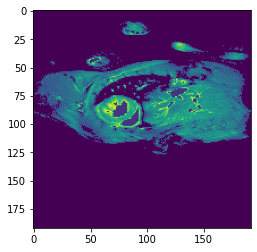

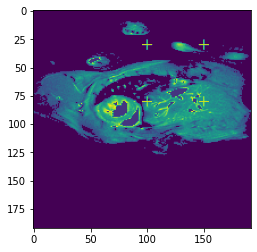

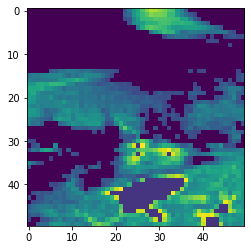

In [ ]:
#do it for one img

image_index = 6

img = dataset.image_list[image_index]
filename = dataset.filenames[image_index]
filename = filename[:(filename.find('.'))]
img = np.array(img/10).astype(np.uint8)
print("NORMAL shape:", img.shape, "min:", np.min(img), " max:", np.max(img), " filename:", filename)

fsize = 50
x = 30
y = 100
cords = [[x+fsize,y], [x+fsize,y+fsize], [x,y+fsize], [x,y]]

plt.imshow(img)
plt.show()

cords_viz = visualize_cords(cords)
# plt.imshow(cords_viz)
# plt.show()

img_with_cords = visualize_cords(cords, copy.copy(img))
plt.imshow(img_with_cords)
plt.show()

cutted_image = cat_from_img(img, fsize, x, y)
plt.imshow(cutted_image)
plt.show()

In [ ]:
out_filename = OUT_DIR + current_dir + "/" + filename + "_cutted.npy"
mask_filename = MASKS_DIR + current_dir + "/" + filename + "_mask.npy"
with open(out_filename, 'wb') as f:
    np.save(f, cutted_image)
    print("Saved cutted file:", out_filename)
# with open(out_filename, 'rb') as f:
#     a = np.load(f)
#     plt.imshow(a)
#     plt.show()
with open(mask_filename, 'wb') as f:
    np.save(f, cords_viz)
    print("Saved mask:", mask_filename)
# with open(mask_filename, 'rb') as f:
#     a = np.load(f)
#     plt.imshow(a)
#     plt.show()

Saved cutted file: /content/drive/My Drive/magisterka22/dane/Version2/Train/Rectangle/Kontrola/Kopia CTL_8tyg_N3_T1maps_cutted.npy
Saved mask: /content/drive/My Drive/magisterka22/dane/HeartMasks/Train/Rectangle/Kontrola/Kopia CTL_8tyg_N3_T1maps_mask.npy
